# WMT of tendency terms
## CM2.6
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

In [1]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.214cd83198974e4ba90b692d7d7e897f/status,


In [22]:
cluster.close()
client.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated
#import coiled
import distributed

In [3]:
cluster = coiled.Cluster(n_workers=30, account='events', name='scipy-test', shutdown_on_close=False, package_sync_ignore=["jpeg"])
client = cluster.get_client()

Output()

earthdata 0.2.2 has requirement python-benedict<0.26,>=0.25, but you have python-benedict 0.24.3.

xmip 0.7.1 has requirement xgcm<0.7.0, but you have xgcm 0.8.1.

Package - earthdata, Pip check had the following issues that need resolving: 
earthdata 0.2.2 has requirement python-benedict<0.26,>=0.25, but you have python-benedict 0.24.3.

Package - xmip, Pip check had the following issues that need resolving: 
xmip 0.7.1 has requirement xgcm<0.7.0, but you have xgcm 0.8.1.

╭──────────────────────────────────── Not Synced with Cluster ─────────────────────────────────────╮
│             ╷                                                                        ╷           │
│   Package   │ Error                                                                  │ Risk      │
│ ╶───────────┼────────────────────────────────────────────────────────────────────────┼─────────╴ │
│   xmip      │ Pip check had the following issues that need resolving:                │ Warning   │
│             │ xmip 0.7.1 has requirement xgcm<0.7.0, but you have xgcm 0.8.1.        │           │
│   earthdata │ Pip check had the following issues that need resolving:                │ Warning   │
│             │ earthdata 0.2.2 has requirement python-benedict<0.26,>=0.25, but you   │           │
│             │ have python-benedict 0.24.3.                                           │           │
│             ╵                                                                        ╵           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

In [4]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(basin_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/' + 
                                              basin_file + '.zarr'))
    return ds

In [5]:
rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))

In [6]:
basin_names = list(['natl_ocean','npac_ocean', 'arc_ocean', 'south_ocean', 'ind_ocean'])
basin_ds = []

In [7]:
#load in basin tendencies
for name in basin_names:
    basin_ds.append(open_ds(name))
    for ds in basin_ds:
        globals()[name] = ds

In [8]:
arc1223 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/arc_ocean_last1223.zarr'))

In [9]:
arc_ocean = xr.concat([arc_ocean.isel(time=slice(None, -2)), arc1223], dim='time')

In [10]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [12]:
res = tend.rho_lap + tend.cabbeling - tend.sss - tend.sst

NameError: name 'tend' is not defined

In [ ]:
res.isel(time=100).plot(robust=True, vmin=1e-10);

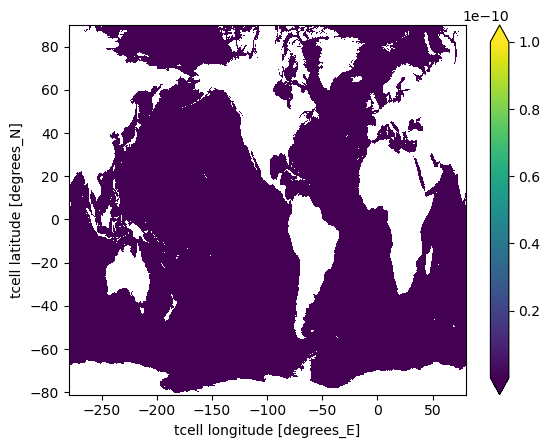

In [20]:
res.mean('time').plot(robust=True, vmin=1e-10);

In [11]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_surf_tends(basin_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf/' + basin_file + '_tends.zarr'))
    return ds

In [12]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_histograms(basin_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/basin-histograms/' + 
                                              basin_file + '.zarr'))
    return ds

def open_surf_histograms(basin_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/' + 
                                              basin_file + '.zarr'))
    return ds

In [13]:
surf_names = list(['natl_ocean_surf', 'satl_ocean_surf', 'npac_ocean_surf', 
                   'spac_ocean_surf', 'arc_ocean_surf', 'south_ocean_surf', 'ind_ocean_surf'])
surf_hist_names = list(['natl_hist_surf', 'satl_hist_surf', 'npac_hist_surf', 
                   'spac_hist_surf', 'arc_hist_surf', 'south_hist_surf', 'ind_hist_surf'])
hist_names = list(['natl_hist', 'npac_hist', 'arc_hist', 'south_hist', 'ind_hist'])
surf_tends = list()
surf_hist = list()
hist = list()

In [14]:
#load in basin surface histograms
for name in surf_hist_names:
    surf_hist.append(open_surf_histograms(name))
    for ds in surf_hist:
        globals()[name] = ds

In [15]:
#load in basin mixing histograms
for name in hist_names:
    hist.append(open_histograms(name))
    for ds in hist:
        globals()[name] = ds

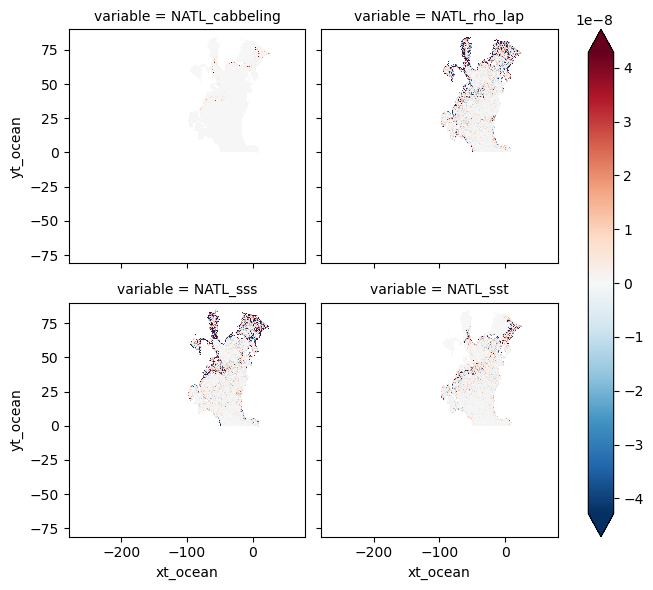

In [33]:
natl_ocean.isel(time=20).to_array().plot(col='variable', col_wrap=2, robust=True)

# Create histograms

In [21]:
#assign each region index value to basin name

north_atlantic_ocean = 0
south_atlantic_ocean = 1
north_pacific_ocean = 2
south_pacific_ocean = 3
south_china_seas = 4
indian_ocean = 5
arctic_ocean = 6
southern_ocean = 7
black_sea = 8
med_sea = 9
red_sea = 10
baltic_sea = 12 #no 11

In [28]:
#mask = mask.mask
delta_rho = 0.1
rho = rho#rho.rho_test
rho_bins = np.arange(1015, 1035, delta_rho)
avg_mld = ds.mld.mean('time').compute()
weights = coord.area_t*avg_mld

In [29]:
from xhistogram.xarray import histogram
def histogram_function(ds, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(ds[variable].fillna(0.)*(weights).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho

# Plot ann mean

In [31]:
residual = ((natl_hist.rho_lap - natl_hist.sss - 
             natl_hist.sst + natl_hist.cabbeling)/1e6).isel(time=200)

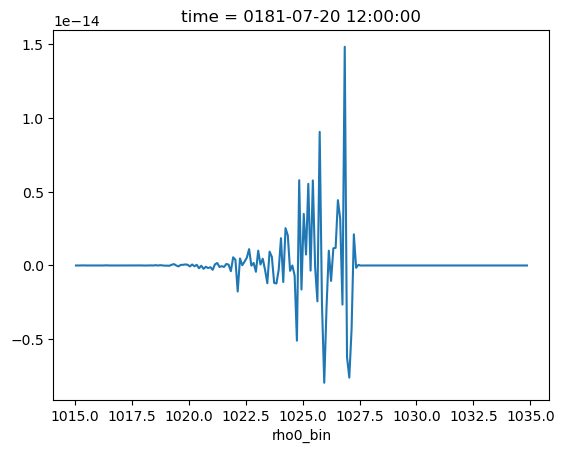

In [32]:
residual.plot()

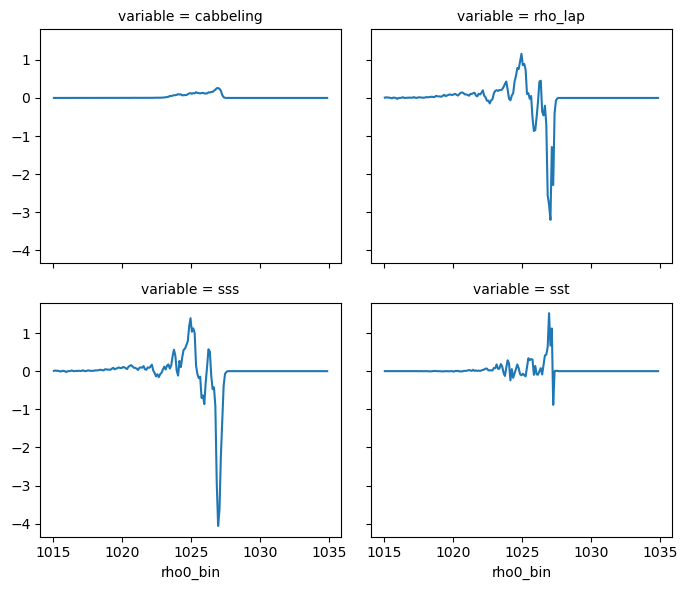

In [29]:
(natl_hist.isel(time=200)/1e6).to_array().plot(col='variable', col_wrap=2)

In [17]:
natl_hist_surf

<xarray.Dataset>
Dimensions:          (time: 240, rho0_bin: 199)
Coordinates:
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
  * time             (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
Data variables:
    OMEGA_surf_heat  (time, rho0_bin) float32 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_surf_salt  (time, rho0_bin) float32 dask.array<chunksize=(1, 199), meta=np.ndarray>

In [20]:
def ann_mean(mix, surf, basin_title):
    plt.rcParams['axes.grid']=True
    plt.rcParams['figure.autolayout']= False
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    line_colors=['blue', 'k', 
                 'orange', 'green']
    line_surf = ['purple', 'yellow']
    labels_mix = ['cabbeling', r'$\rho$', 'S', r'$\theta$']
    labels_surf = [r'$\theta_{S}$', r'S$_S$']
    
    for (i,j,k) in zip(list(mix.data_vars), line_colors, labels_mix):
        (mix[i].mean('time')/1e6).plot(label=k, color=j, ax=ax0)
    
    #plotting mixing residual
    #((mix.rho_lap + mix.cabbeling -
      #mix.sss - mix.sst).mean('time')/1e6).plot(label='residual', color='grey', 
                                                               # linestyle='dashed', ax=ax0)
    for (i,j,k) in zip(list(surf.data_vars), line_surf, labels_surf):
        (surf[i].mean('time')/1e6).plot(label=k, color=j, ax=ax1)
    ax0.legend()
    ax0.set_xlim(1016,1030)
    ax0.set_ylim(-2.5, 1.5)
    ax0.set_ylabel(r'Transformation (Sv)', fontsize=16)
    #ax0.grid()
    ax0.set_title('Mixing')
    ax0.set_xlabel('')
    
    ax1.legend()
    ax1.set_xlim(1016,1030)
    ax1.set_ylim(-15, 30)
    ax1.set_ylabel('')
    #ax1.grid()
    ax1.set_title('Air-Sea')
    ax1.set_xlabel('')
    
    #fig.supxlabel('Rho bins', fontsize=16)
    plt.suptitle('CM2.6', fontsize=20)
    plt.savefig(f'{basin_title}_ann_mean_hist_fig.pdf');

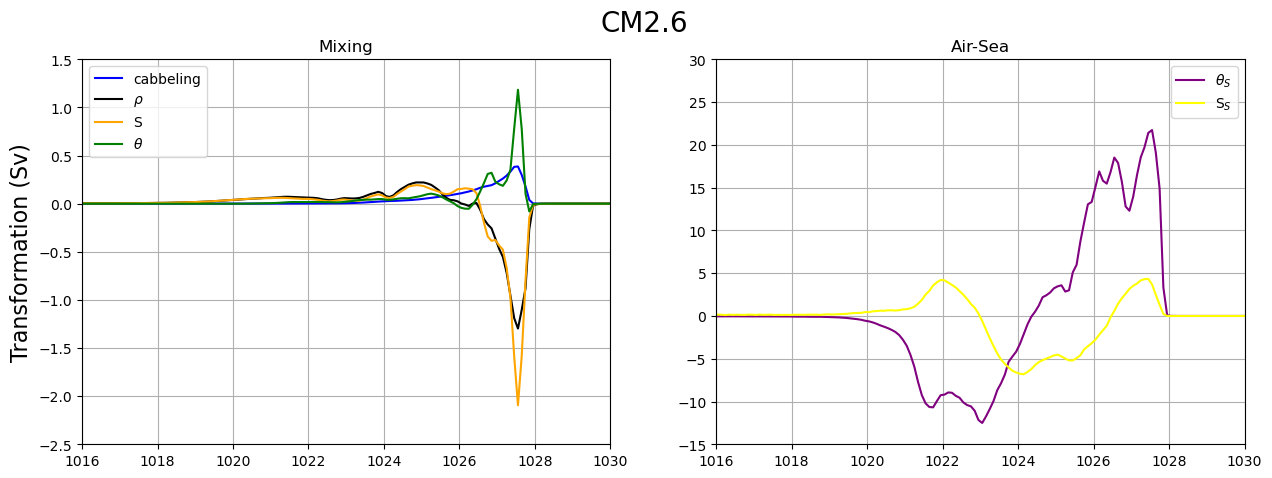

In [21]:
ann_mean(natl_hist, natl_hist_surf, 'NATL')

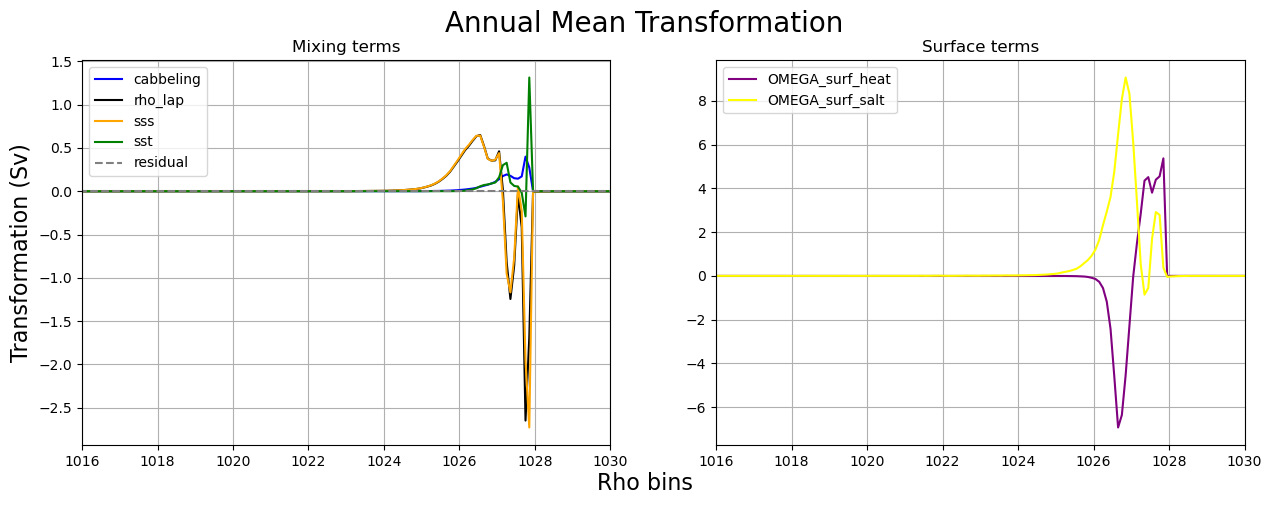

In [23]:
ann_mean(south_hist, south_hist_surf, 'SATL')

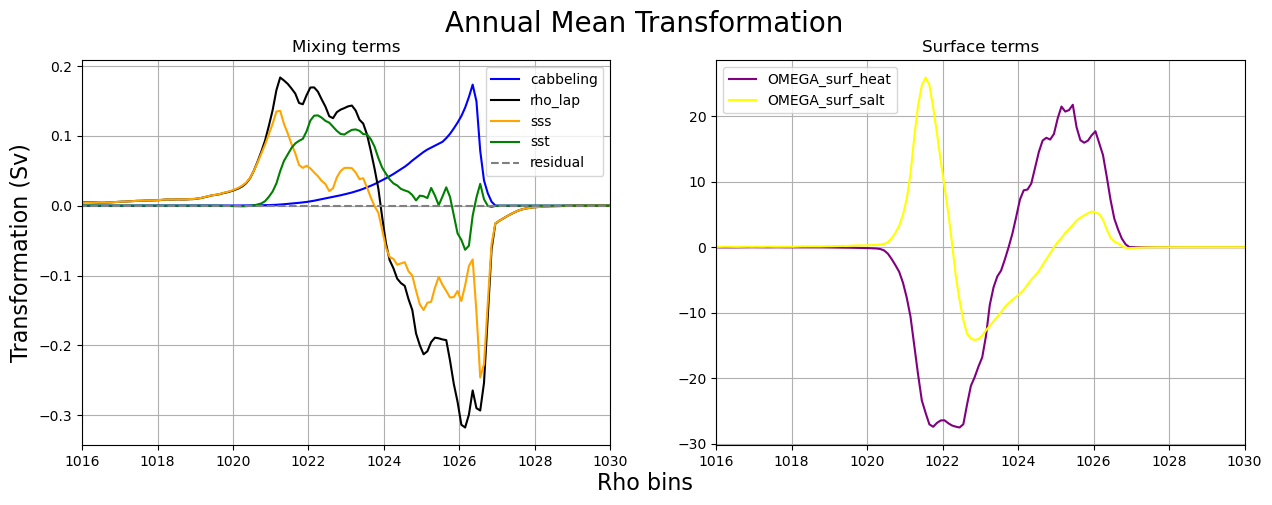

In [24]:
ann_mean(npac_hist, npac_hist_surf, 'NPAC')

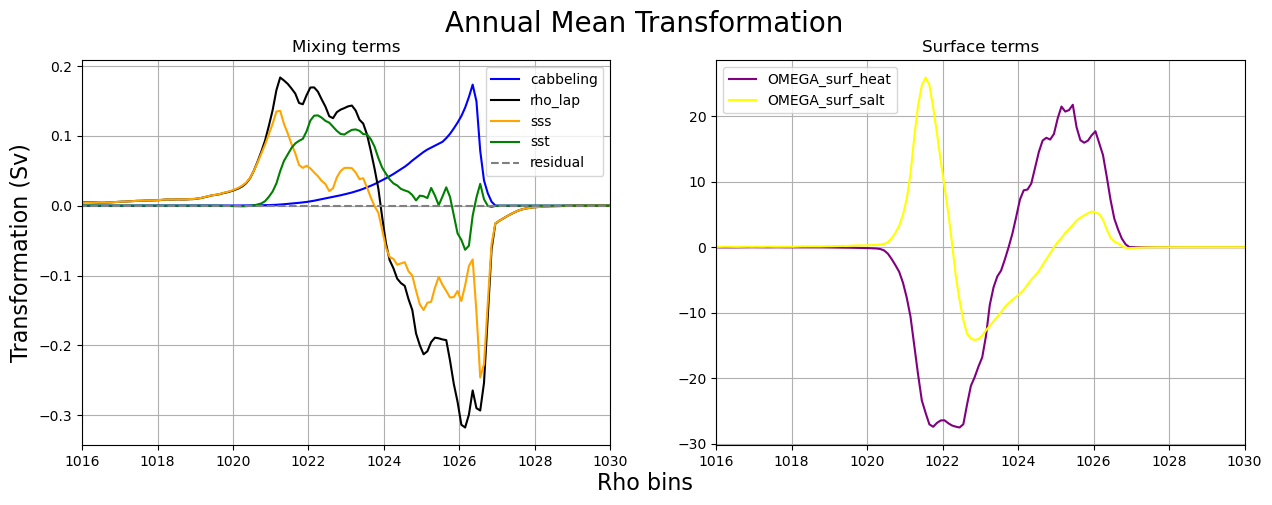

In [28]:
ann_mean(npac_hist, npac_hist_surf, 'SPAC')

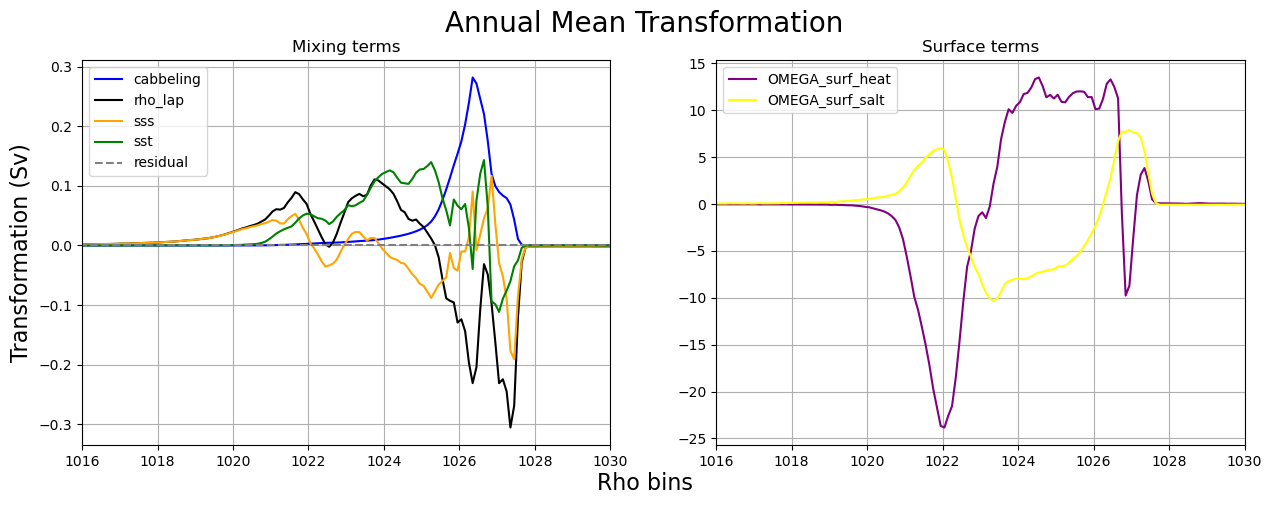

In [25]:
ann_mean(ind_hist, ind_hist_surf, 'IND')

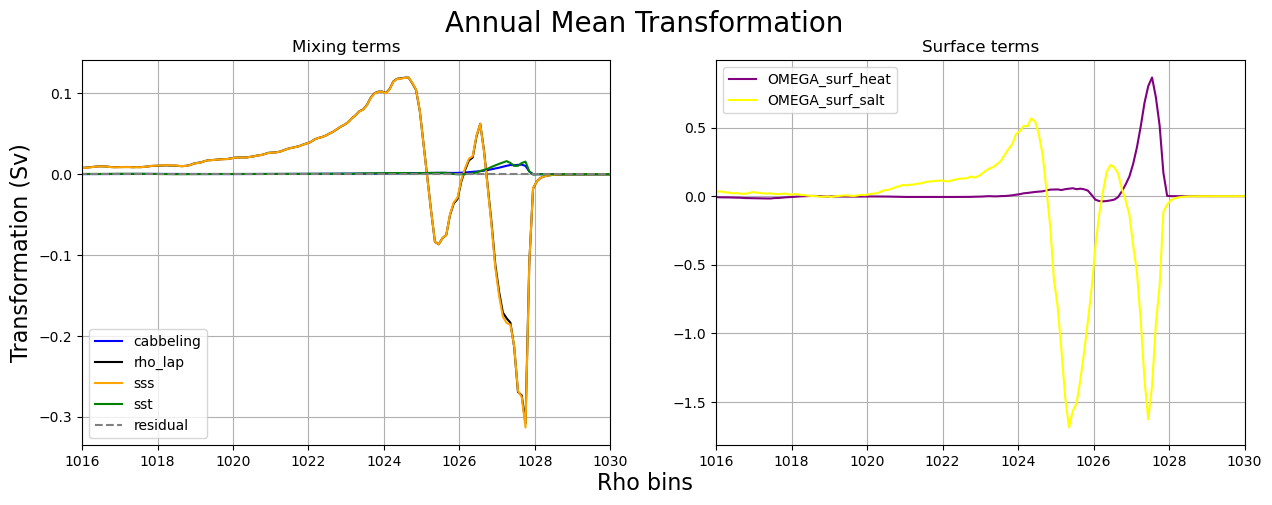

In [26]:
ann_mean(arc_hist, arc_hist_surf, 'ARC')

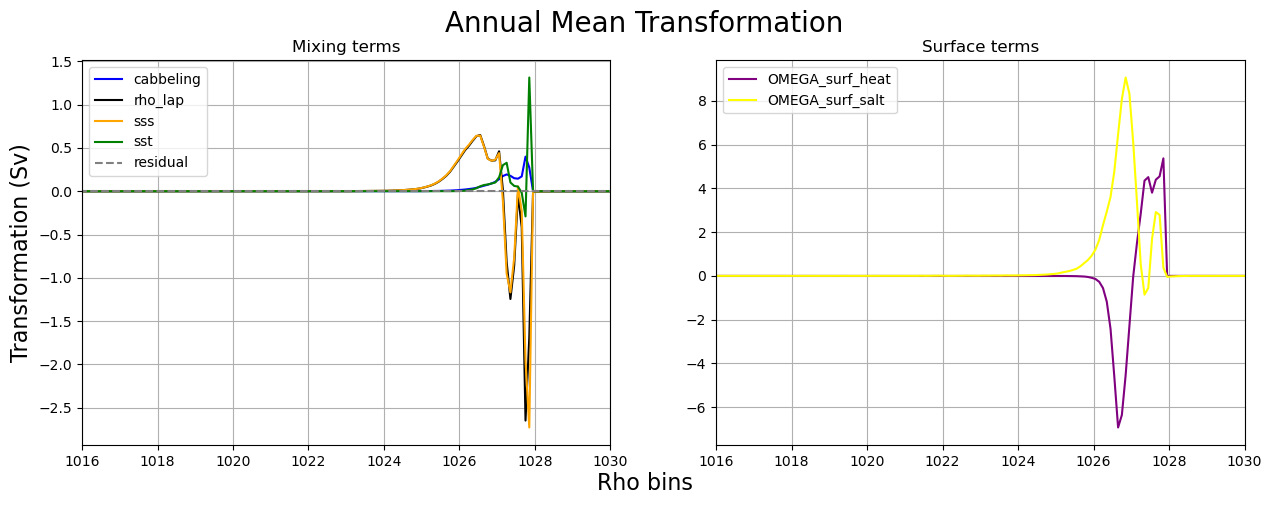

In [27]:
ann_mean(south_hist, south_hist_surf, 'SOUTH')

[Back to top](#top)

# Save mixing histograms

In [48]:
from tqdm import tqdm
import zarr

def to_zarr_split(ds, mapper, split_dim="time", split_interval=1):
    print(f"Writing to {mapper.root} ...")

    n = len(ds[split_dim])
    splits = list(range(0, n, split_interval))

    # Make sure the last item in the list covers the full length
    # of the time on our dataset
    if splits[-1] != n:
        splits = splits + [n]

    split_datasets = []
    for ii in range(len(splits) - 1):
        start = splits[ii]
        stop = splits[ii + 1]
        split_datasets.append(ds.isel({split_dim: slice(start, stop)}))

    # write the first array
    # TODO: move the first write to the loop so it is counted in the viz bar
    split_datasets[0].to_zarr(mapper)
    for ds_split in tqdm(split_datasets[1:None]):
        ds_split.to_zarr(mapper, append_dim=split_dim)

    # overwrite the split dimension as single chunk (this should reproduce
    # what xr.to_zarr would do
    g = zarr.open_group(mapper)
    del g[split_dim]
    
    ds[[split_dim]].load().to_zarr(mapper, mode='a')
    zarr.consolidate_metadata(mapper)

In [49]:
hist_names

['natl_hist', 'npac_hist', 'arc_hist', 'south_hist', 'ind_hist']

In [50]:
hist_ds = [natl_hist, npac_hist, arc_hist, south_hist, ind_hist]

In [53]:
for (i,j) in zip(hist_names, hist_ds):
    mapper = gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/basin-histograms/' + i + '.zarr')
    to_zarr_split(j, mapper)

Writing to pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/basin-histograms/natl_hist.zarr ...


100%|██████████| 7304/7304 [14:24:01<00:00,  7.10s/it]  


Writing to pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/basin-histograms/npac_hist.zarr ...


100%|██████████| 7304/7304 [14:30:20<00:00,  7.15s/it]  


Writing to pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/basin-histograms/arc_hist.zarr ...


100%|██████████| 7304/7304 [14:21:23<00:00,  7.08s/it]  


Writing to pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/basin-histograms/south_hist.zarr ...


100%|██████████| 7304/7304 [14:08:14<00:00,  6.97s/it]  


Writing to pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/basin-histograms/ind_hist.zarr ...


100%|██████████| 7304/7304 [13:20:08<00:00,  6.57s/it]  
